In [1]:
import sys
import json
import torch
from torch import nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification\
    , BertForPreTraining, AutoModel
from transformers import XLMTokenizer, XLMWithLMHeadModel


from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, mean_squared_error
import time

In [2]:
from transformers import XLMTokenizer, XLMWithLMHeadModel
tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
torch.manual_seed(7)
random.seed(7)
np.random.seed(7)
# Setting PyTorch's required configuration variables for reproducibility.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms(False)

In [77]:
PRE_TRAINED_MODEL = 'bert-base-multilingual-cased'
#PRE_TRAINED_MODEL = 'xlm-mlm-100-1280'



In [78]:
MAXTOKENS = 5
NUM_EPOCHS = 2000  # default maximum number of epochs
BERT_EMB = 768  # set to either 768 or 1024 for BERT-Base and BERT-Large models respectively
BS = 8  # batch size
INITIAL_LR = 1e-5  # initial learning rate
save_epochs = [1, 2, 3, 4, 5, 6, 7]  # these are the epoch numbers (starting from 1) to test the model on the test set
# and save the model checkpoint.
EARLY_STOP_PATIENCE = 30  # If model does not improve for this number of epochs, training stops.

# Setting GPU cards to use for training the model. Make sure you read our paper to figure out if you have enough GPU
# memory. If not, you can change all of them to 'cpu' to use CPU instead of GPU. By the way, two 24 GB GPU cards are
# enough for current configuration, but in case of developing based on this you may need more (that's why there are
# three cards declared here)
# CUDA_0 = 'cuda:1'
# CUDA_1 = 'cuda:1'
# CUDA_2 = 'cuda:1'
args = sys.argv
epochs = NUM_EPOCHS

In [6]:
original_df = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/train_final.csv")
original_df

,Unnamed: 0,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label
0,189,काग़ज़,کاغذ,kaːɣəz,kɒɣz,0.500000,0.166667,0.170139,0.187500,1.458333,0.500000,1
1,6907,बहुत खूब,Refulgent,bəɦutə kʰuːb,refulgent,0.916667,0.500000,0.182292,0.204861,2.291667,0.916667,0
2,559,तेहरान,تیار,teɦraːn,tjɒr,0.714286,0.428571,0.300595,0.351190,3.000000,0.714286,0
3,7069,प्रायश्चित करना,توبه کردن,praːjʃt͡ʃitə kərnaː,tvbh krdn,0.789474,0.526316,0.338816,0.383772,3.322368,0.789474,0
4,6848,अटपटा,عجیب,aʈpəʈaː,ʔd͡ʒjb,1.000000,0.857143,0.360119,0.404762,3.589286,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4395,5996,दिलबर,دیوان,dilbər,djvɒn,0.833333,0.333333,0.225694,0.263889,2.416667,0.833333,0
4396,276,ख़ुशामद,خش‌آمد,xuʃaːməd,xʃ‌ɒmd,0.500000,0.250000,0.239583,0.265625,2.000000,0.500000,1
4397,6638,प्रसिद्ध,مشهور,prəsidd̤ə,mʃhvr,1.000000,0.777778,0.379630,0.439815,4.097222,1.000000,0
4398,7845,वर्ज़िश,واقعی,vərziʃ,vɒɣʔj,0.833333,0.666667,0.270833,0.312500,3.395833,0.833333,0


In [7]:
l1 = list(original_df["loan_word"])
l2 = list(original_df["original_word"])

In [ ]:
original_df = original_df.loc[original_df["original_word"]!='Refulgent']


In [ ]:
original_df 

In [79]:
MAXTOKENS = 512
BERT_EMB = 768  # set to either 768 or 1024 for BERT-Base and BERT-Large models respectively
#CUDA_0 = 'cuda:1'
#CUDA_1 = 'cuda:1'
#CUDA_2 = 'cuda:1'
CUDA_0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#CUDA_1 = 'cuda:0'
#CUDA_2 = 'cuda:0'

# The function for printing in both console and a given log file.
def myprint(mystr, logfile):
    print(mystr)
    print(mystr, file=logfile)


# The function for loading datasets from parallel tsv files and returning texts in lists.
def load_data(file_name):
    try:
        # f = open(file_name)
        f = pd.read_csv(file_name, sep='\t', names=['l1_text', 'l2_text'])#, 'extra'])
    except:
        print('my log: could not read file')
        exit()
    print("This many number of rows were removed from " + file_name.split("/")[-1] + " due to having missing values: ",
          f.shape[0] - f.dropna().shape[0])
    f.dropna(inplace=True)
    l1_texts = f['l1_text'].values.tolist()
    l2_texts = f['l2_text'].values.tolist()
    print(len(l1_texts), len(l2_texts))
    print(l1_texts[500])
    print("\n")
    print(l2_texts[500])
    return l1_texts, l2_texts


# Overriding the Dataset class required for the use of PyTorch's data loader classes.
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, l1_encodings, l2_encodings):
        self.l1_encodings = l1_encodings
        self.l2_encodings = l2_encodings

    def __getitem__(self, idx):
        item = {('l1_' + key): torch.tensor(val[idx]) for key, val in self.l1_encodings.items()}
        item2 = {('l2_' + key): torch.tensor(val[idx]) for key, val in self.l2_encodings.items()}
        item.update(item2)
        # item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])


class MyDataset1(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])


class MyModel(nn.Module):
    # Each component other than the Transformer, are in a sequential layer (it is not required obviously, but it is
    # possible to stack them with other layers if desired)
    def __init__(self, base_model, n_classes, dropout=0.05):
        super().__init__()
        # self.base_model = base_model.to(CUDA_0)
        self.transformation_learner = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU()
        ).to(CUDA_0)

    def forward(self, input, **kwargs):
        l1_pooler_output = input
        # l2 = input2
        # if 'l1_attention_mask' in kwargs:
        #     l1_attention_mask = kwargs['l1_attention_mask']
            # l2_attention_mask = kwargs['l2_attention_mask']
        # else:
        #     print("my err: attention mask is not set, error maybe")
        # here we use only the CLS token
        # l1_pooler_output = self.base_model(l1.to(CUDA_0), attention_mask=l1_attention_mask.to(CUDA_0)).pooler_output
        myoutput = self.transformation_learner(l1_pooler_output)
        return myoutput


# The function to compute and print the performance measure scores using sklearn implementations.
def evaluate_model(labels, predictions, titlestr, logfile):
    myprint(titlestr, logfile)
    conf_matrix = confusion_matrix(labels, predictions)
    myprint("Confusion matrix- \n" + str(conf_matrix), logfile)
    acc_score = accuracy_score(labels, predictions)
    myprint('  Accuracy Score: {0:.2f}'.format(acc_score), logfile)
    myprint('Report', logfile)
    cls_rep = classification_report(labels, predictions)
    myprint(cls_rep, logfile)
    return f1_score(labels, predictions)  # return f-1 for positive class (sarcasm) as the early stopping measure.

In [ ]:
print("key word pair number: ",len(l1))

In [82]:
with torch.no_grad():
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l5, truncation=False, padding=True, max_length=MAXTOKENS)
    l2_encodings = tokenizer(l6, truncation=False, padding=True, max_length=MAXTOKENS)
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = BertModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    sim_lst = []
    for step, batch in enumerate(data_loader):
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
                                      attention_mask=batch['l1_attention_mask'].to(CUDA_0),
                                      return_dict=True).last_hidden_state[:, 1, :]
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
                                      attention_mask=batch['l2_attention_mask'].to(CUDA_0),
                                      return_dict=True).last_hidden_state[:, 1, :]
        sims = cos_s(l1_vector, l2_vector).data.cpu().numpy()
        sim_lst.extend(list(sims))
print(len(sim_lst))
      # print("Similarities: ")
      # for i in range(len(sims)):
      #   print(l1[i], ' and ', l2[i], ' : ', sims[i])

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2268: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y






8450


In [43]:
import pandas as pd
equiv = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Synonyms.csv")
rand = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Randoms.csv")

In [10]:
equiv

,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen
0,छोड़ देना,دست برداشتن از,t͡ʃʰoɽə denaː,dst brdɒʃtn ɒz,0.928571,0.500000,0.352679,0.383929,3.750000,0.928571
1,छोड़ देना,رد کردن,t͡ʃʰoɽə denaː,rd krdn,0.846154,0.461538,0.232372,0.275641,3.048077,0.846154
2,छोड़ देना,دست بردارید,t͡ʃʰoɽə denaː,dst brdɒrjd,0.923077,0.615385,0.258013,0.301282,3.317308,0.923077
3,छोड़ देना,رها کردن,t͡ʃʰoɽə denaː,rhɒ krdn,0.846154,0.461538,0.190705,0.230769,2.615385,0.846154
4,छोड़ देना,کویر,t͡ʃʰoɽə denaː,kvjr,1.000000,0.461538,0.323718,0.375000,3.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
8445,उमंग,اشتیاق,uməŋɡə,ɒʃtjɒɣ,1.000000,0.833333,0.250000,0.277778,5.270833,1.000000
8446,परोक्ष,مورب,pərokʂə,mvrb,0.857143,0.857143,0.473214,0.523810,4.892857,0.857143
8447,परोक्ष,خودسر,pərokʂə,xvdsr,1.000000,0.857143,0.392857,0.464286,4.375000,1.000000
8448,स्वच्छंद,مورب,svət͡ʃt͡ʃʰəndə,mvrb,0.928571,0.571429,0.361607,0.404762,3.196429,0.928571


In [80]:
l5 = list(equiv['loan_word'])
l6=list(equiv['original_word'])
len(l5)

8450

In [45]:
l7 = l5[0:7]
l8=l6[0:7]
l7,l8

(['हौसला', 'अंगूर', 'अंगूरी', 'अंजाम', 'अंदर', 'अंदरुनी', 'अंदाज़'],
 ['انگور', 'انگوری', 'انجام', 'اندر', 'اندرونی', 'اندازه', 'اندیشه'])

In [46]:
base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
l1_encodings = tokenizer(text =l7,text_pair = l8 , truncation=False, padding=True, max_length=MAXTOKENS)
l2_encodings = tokenizer(text =l8,text_pair = l7, truncation=False, padding=True, max_length=MAXTOKENS)
l2_encodings

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2268: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


{'input_ids': [[0, 47790, 7657, 1, 179243, 167068, 1, 2], [0, 47790, 28610, 1, 150306, 148216, 1, 2], [0, 31691, 1, 150306, 93491, 14629, 1, 2], [0, 155182, 1, 94209, 29165, 8174, 1, 2], [0, 4571, 42941, 14468, 1, 172708, 1, 2], [0, 86287, 1, 94209, 24720, 49562, 28366, 1], [0, 114099, 44805, 1, 178717, 25670, 3910, 1]], 'token_type_ids': [[0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [47]:
tokens=[0, 47790, 7657, 1, 179243, 167068, 1, 2]
tokenizer.decode(tokens)


'<s>انگور </s>हौसला </s><pad>'

In [22]:
l7, l8

(['छोड़ देना',
  'छोड़ देना',
  'छोड़ देना',
  'छोड़ देना',
  'छोड़ देना',
  'छोड़ देना',
  'छोड़ देना'],
 ['دست برداشتن از',
  'رد کردن',
  'دست بردارید',
  'رها کردن',
  'کویر',
  'ترک',
  'رها کردن'])

In [38]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    #l1_encodings = tokenizer(l7, truncation=True, padding=True, max_length=MAXTOKENS, return_tensors="pt")
    #l2_encodings = tokenizer(l8, truncation=True, padding=True, max_length=MAXTOKENS, return_tensors="pt")
    l1_encodings = tokenizer(text =l7,text_pair = l8 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(text =l8,text_pair = l7, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi_exp = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0), output_hidden_states =True)[0]
        print(len(l1_vector))
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True)[0] 
        #print(l1_vector.hidden_states,l2_vector.hidden_states )
        sims = cos_s(l1_vector[:,4,:],l2_vector[:,4,:]).data.cpu().numpy()
        xlm_sim_lst_equi_exp.extend(list(sims))
#print(len(sim_lst_equi))

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2268: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: To c






7


In [39]:
l2_vector.shape

torch.Size([7, 11, 200000])

# Cosine similarities using XLM layers, middle and last. 

In [67]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(l6, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l1_encodings = tokenizer(text =l5,text_pair = l6 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l2_encodings = tokenizer(text =l6,text_pair = l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),output_hidden_states =True )[0] 
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True) [0]
        #print(l1_vector[0][0].shape,l2_vector[1].shape )
        sims = cos_s(l1_vector[:,0,:],l2_vector[:,0,:]).data.cpu().numpy()
        xlm_sim_lst_equi.extend(list(sims))
#print(len(sim_lst_equi))
      # print("Similarities: ")
      # for i in range(len(sims)):
      #   print(l1[i], ' and ', l2[i], ' : ', sims[i])

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2268: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [65]:
l2_vector.shape

torch.Size([2, 14, 200000])

# Random words Cosine sim using SOS token no clear threshold/separation between equivalent words, no truncation 

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

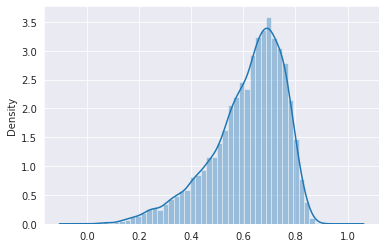

In [53]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using BOS/classification  token no clear threshold/separation between equivalent words, no truncation 

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

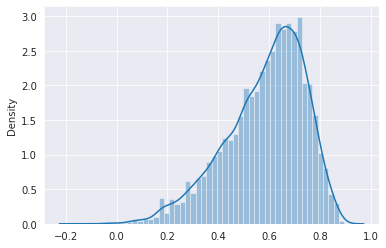

In [68]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using middle token, some threshold emerges between cosine sims , no truncation of words

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

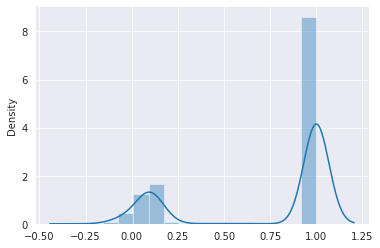

In [66]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using EOS token, huge peak with cos sim of 1 , no truncation of words

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

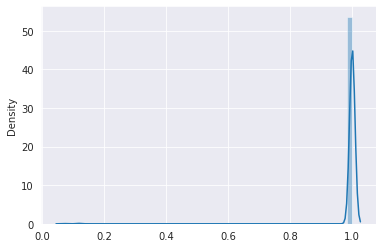

In [63]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

In [83]:
equiv["xlm_cos_similarity"] = xlm_sim_lst_equi
equiv["mbert_cos_similarity"] =sim_lst
equiv 

,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,xlm_cos_similarity,mbert_cos_similarity
0,छोड़ देना,دست برداشتن از,t͡ʃʰoɽə denaː,dst brdɒʃtn ɒz,0.928571,0.500000,0.352679,0.383929,3.750000,0.928571,0.485205,0.379804
1,छोड़ देना,رد کردن,t͡ʃʰoɽə denaː,rd krdn,0.846154,0.461538,0.232372,0.275641,3.048077,0.846154,0.340752,0.527307
2,छोड़ देना,دست بردارید,t͡ʃʰoɽə denaː,dst brdɒrjd,0.923077,0.615385,0.258013,0.301282,3.317308,0.923077,0.617882,0.498394
3,छोड़ देना,رها کردن,t͡ʃʰoɽə denaː,rhɒ krdn,0.846154,0.461538,0.190705,0.230769,2.615385,0.846154,0.407228,0.540521
4,छोड़ देना,کویر,t͡ʃʰoɽə denaː,kvjr,1.000000,0.461538,0.323718,0.375000,3.000000,1.000000,0.619039,0.476639
...,...,...,...,...,...,...,...,...,...,...,...,...
8445,उमंग,اشتیاق,uməŋɡə,ɒʃtjɒɣ,1.000000,0.833333,0.250000,0.277778,5.270833,1.000000,0.817665,0.377121
8446,परोक्ष,مورب,pərokʂə,mvrb,0.857143,0.857143,0.473214,0.523810,4.892857,0.857143,0.681220,0.496681
8447,परोक्ष,خودسر,pərokʂə,xvdsr,1.000000,0.857143,0.392857,0.464286,4.375000,1.000000,0.802228,0.564824
8448,स्वच्छंद,مورب,svət͡ʃt͡ʃʰəndə,mvrb,0.928571,0.571429,0.361607,0.404762,3.196429,0.928571,0.616180,0.521830


# Mean and Std for XLM cos sim

In [87]:
ordered_mean = np.mean(xlm_sim_lst_equi)
 
ordered_std = np.std(xlm_sim_lst_equi)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)

ordered_mean:  0.58425415
ordered_std:  0.15521835


# Mean and Std for mbert cos sim

In [85]:
ordered_mean = np.mean(sim_lst)
 
ordered_std = np.std(sim_lst)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)

ordered_mean:  0.43527302
ordered_std:  0.08650125


# Outliers from Z score for XLM cos sim

In [88]:
threshold = 2
xlm_ordered_outlier_idx = []
for i in range(len(xlm_sim_lst_equi)):
    z = abs(xlm_sim_lst_equi[i]-ordered_mean)/ordered_std
    if z > threshold:
        xlm_ordered_outlier_idx.append(i)
print('outlier indices are', xlm_ordered_outlier_idx, len(xlm_ordered_outlier_idx))

outlier indices are [9, 31, 44, 53, 75, 77, 86, 97, 100, 108, 183, 201, 215, 229, 230, 231, 233, 239, 327, 329, 333, 351, 357, 363, 485, 488, 499, 506, 513, 523, 533, 538, 588, 606, 624, 637, 645, 653, 661, 677, 693, 708, 821, 832, 837, 843, 854, 876, 971, 976, 979, 989, 995, 1001, 1007, 1014, 1021, 1028, 1042, 1049, 1057, 1123, 1243, 1262, 1274, 1300, 1318, 1324, 1353, 1357, 1368, 1372, 1373, 1377, 1435, 1444, 1445, 1467, 1469, 1538, 1613, 1670, 1710, 1712, 1741, 1878, 1882, 1883, 1884, 1885, 1908, 1912, 1913, 1914, 1915, 1970, 1974, 1992, 2019, 2244, 2245, 2248, 2253, 2254, 2255, 2257, 2297, 2298, 2300, 2304, 2306, 2325, 2327, 2328, 2346, 2348, 2349, 2377, 2412, 2461, 2463, 2468, 2469, 2487, 2493, 2499, 2519, 2528, 2621, 2628, 2633, 2715, 2732, 2735, 2736, 2739, 2844, 2847, 2897, 2988, 3020, 3090, 3092, 3121, 3123, 3125, 3130, 3132, 3134, 3288, 3289, 3319, 3320, 3321, 3351, 3359, 3367, 3389, 3453, 3615, 3664, 3667, 3674, 3681, 3688, 3695, 3709, 3799, 3951, 3976, 4065, 4183, 4200, 421

In [89]:
xlm_equiv_outlier = equiv.loc[xlm_ordered_outlier_idx]


# Outliers with low cos sim from XLM and Mbert

In [117]:
equiv_outlier_lowcos = xlm_equiv_outlier.loc[(xlm_equiv_outlier['xlm_cos_similarity'] <0.35) & (xlm_equiv_outlier['mbert_cos_similarity']<0.35)]
equiv_outlier_lowcos.to_csv('Outliers_XLM_Mbert_lowcosim.csv')

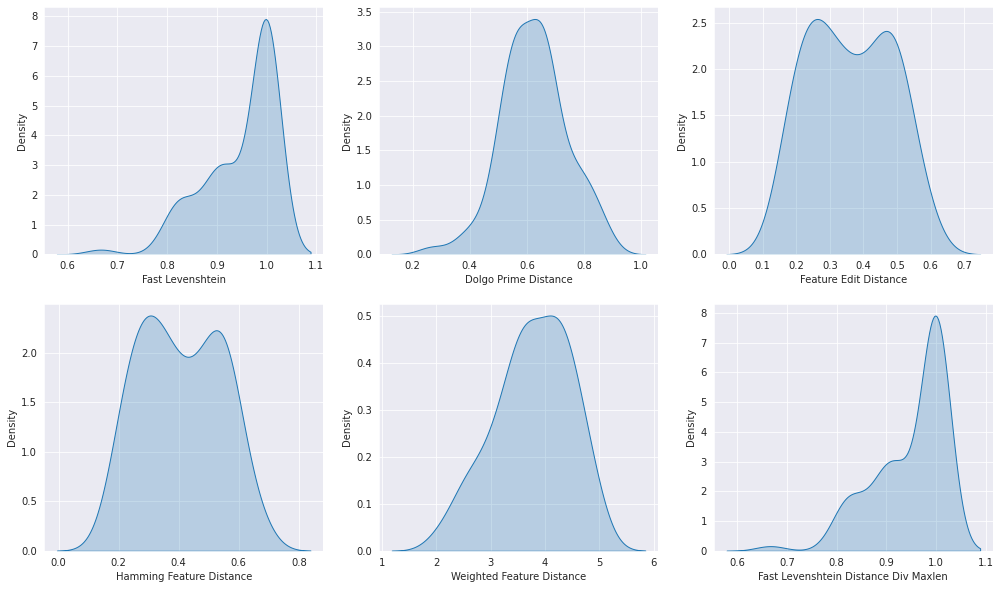

In [112]:

f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_lowcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

# Outliers with high cos sim from XLM and Mbert

In [118]:
equiv_outlier_highcos = equiv.loc[(equiv['xlm_cos_similarity'] >0.68) & (equiv['mbert_cos_similarity']>0.6)]
equiv_outlier_highcos.to_csv('Outliers_XLM_Mbert_highcosim.csv')

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='xlm_cos_similarity', ylabel='Density'>

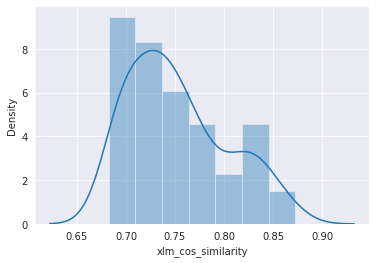

In [115]:
sns.distplot(equiv_outlier_highcos['xlm_cos_similarity'])

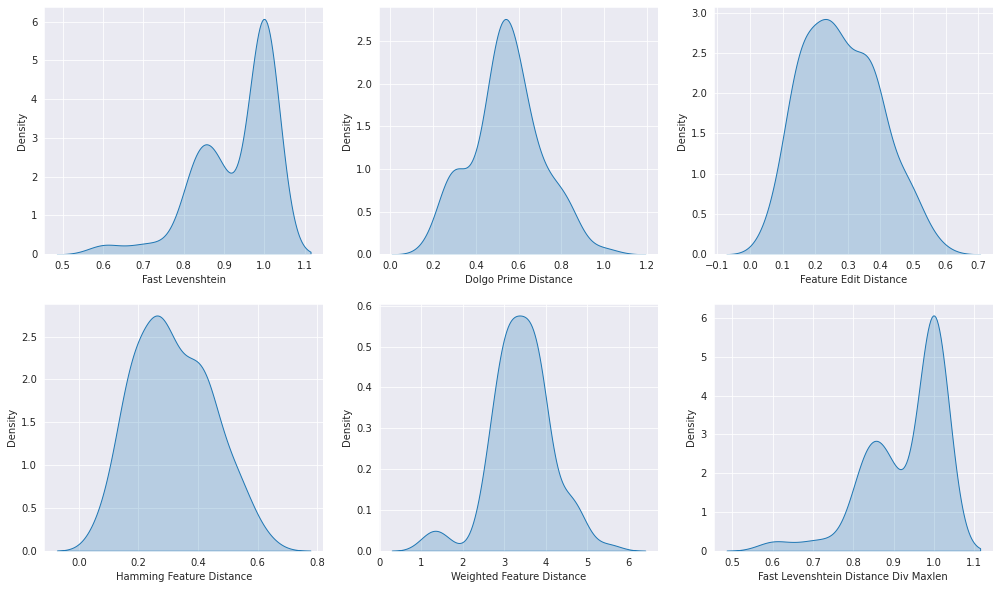

In [116]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_highcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
xlm_equiv_outlier_lowcos = equiv.loc[equiv['xlm_cos_similarity'] <0.23]
xlm_equiv_outlier_lowcos

In [ ]:
xlm_equiv_outlier_highcos = equiv.loc[equiv['xlm_cos_similarity'] ==1]
xlm_equiv_outlier_highcos 

In [ ]:
equiv["xlm_cos_similarity"] = xlm_sim_lst_equi

In [ ]:
equiv

# Cosine similarity and Outliers using M-bert cased

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(sim_lst_equi)

In [ ]:
equiv["cos_similarity"] = sim_lst_equi

In [ ]:
ordered_mean = np.mean(sim_lst_equi)
 
ordered_std = np.std(sim_lst_equi)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)
 

In [ ]:
threshold = 2
ordered_outlier_idx = []
for i in range(len(sim_lst_equi)):
    z = abs(sim_lst_equi[i]-ordered_mean)/ordered_std
    if z > threshold:
        ordered_outlier_idx.append(i)
print('outlier indice are', ordered_outlier_idx)

In [ ]:
len(ordered_outlier_idx)

In [ ]:
equov_outlier = equiv.loc[ordered_outlier_idx]

In [ ]:
equov_outlier

In [ ]:
sns.distplot(equov_outlier['cos_similarity'])

In [ ]:
equiv_outlier_lowcos = equov_outlier.loc[equov_outlier['cos_similarity'] <0.23]
equiv_outlier_lowcos.columns

In [ ]:
equiv_outlier_lowcos[[c for c in equiv_outlier_lowcos.columns if c in edit_dists_names]]
equiv_outlier_lowcos = equiv_outlier_lowcos[[*edit_dists_names]]

In [105]:
edit_dists_names = ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen',
        ]
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr


array([['Fast Levenshtein', 'Dolgo Prime Distance',
        'Feature Edit Distance'],
       ['Hamming Feature Distance', 'Weighted Feature Distance',
        'Fast Levenshtein Distance Div Maxlen']], dtype='<U36')

In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_lowcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
equiv_outlier_highcos = equov_outlier.loc[equov_outlier['cos_similarity'] >0.7]

In [ ]:
equiv_outlier_highcos = equiv_outlier_highcos[[*edit_dists_names]]

In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_highcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

# Get the logits for the train from the cnn/dnn for training the logistic regressor after padding to max length and concatenating loan and original word


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
epitran.download.cedict()

In [109]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
from torch import nn
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline

In [ ]:
#get phonetic features using panPhon
ft = panphon.FeatureTable()

In [ ]:
original_df['features_loan'] = original_df.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
original_df['features_orig'] = original_df.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

In [ ]:
original_df

In [ ]:
#make a flat list of the features for both orig and loan words
#original_df['features_loan'] = original_df['features_loan'].apply(lambda x:sum(x, []))
original_df['features_orig'] = original_df['features_orig'].apply(lambda x:sum(x, []))

In [ ]:
max_len_loan = original_df.loan_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()
max_len_orig = original_df.original_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()

In [ ]:
max_len_loan, max_len_orig

In [ ]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [ ]:
pad_idx_loan = original_df['features_loan'].apply(len)
pad_idx_orig = original_df['features_orig'].apply(len)
pad_idx_loan = np.array(pad_idx_loan)
pad_idx_orig = np.array(pad_idx_orig)

In [ ]:
pad_idx_loan, pad_idx_orig

In [ ]:
arr_loan = np.asarray(original_df['features_loan'])
arr_orig = np.asarray(original_df['features_orig'])
 

In [ ]:
l_loan = []
for i in range(len(arr_loan)):
    a = padarray(arr_loan[i], max_len_loan*24)
    l_loan.append(a)

In [ ]:
l_orig = []
for i in range(len(arr_orig)):
    a = padarray(arr_orig[i], max_len_orig*24)
    l_orig.append(a)

In [ ]:
len(l_orig)

In [ ]:
l_comb = np.concatenate((l_loan, l_orig), axis=1)

In [ ]:
l_comb[0:5]

In [ ]:
lables = np.array(original_df['label']).reshape((-1,1))
lables.shape

In [ ]:
x = np.append(l_comb, lables, axis=1) 

In [ ]:
x.shape
%store x

In [ ]:
%store -r x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
device = 'cpu'

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        return torch.sigmoid(logits), logits
        #return logits

In [ ]:
X_train = x[:,0:1056]
Y_train = x[:,1056].reshape((-1,1))

In [ ]:
X_train.shape, Y_train.shape
 

In [ ]:
model = NeuralNetwork(X_train.shape[1]).to(device)
print(model)

In [ ]:
model

In [ ]:
criterion = nn.BCELoss().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device)

In [ ]:
Y_train

In [ ]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())

In [ ]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
#train for 10000 epochs and get the logits 
test_losses = []
train_losses = []
test_accur = []
train_accur = []
logits = []
for epoch in range(100):

    y_pred = model(X_train.float())[0]
    logits = model(X_train.float())[1]
    #y_pred = model(X_train) 
    #print(y_pred)

    #y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, Y_train.float())
    #train_loss = criterion(y_pred, Y_train)

    if epoch % 100 == 0:
        #train_acc,_ = calculate_accuracy(Y_train, y_pred)

        #y_test_pred = model(X_test.float())
        #y_test_pred = torch.squeeze(y_test_pred)
         

        #test_loss = criterion(y_test_pred, Y_test.float())

        #test_acc, total_corr = calculate_accuracy(Y_test, y_test_pred)
        #print(total_corr)
        
#         print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
# ''')
        print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
        train_losses.append(train_loss)
        #test_losses.append(test_loss)
        
        #test_accur.append(test_acc)
        #train_accur.append(train_acc)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

In [ ]:
logits 

In [ ]:
plt.plot(train_losses)
 

In [ ]:
X = torch.rand(120, 1056, device=device)
X

In [ ]:
pred_probab = model(X.float())[1]

In [ ]:
pred_probab